Heart data shape: (4240, 18)

Classification on Heart Disease dataset

------------------------------------------------------------
Model: Logistic Regression
------------------------------------------------------------
Cross-validation ROC AUC: 0.6869 (+/- 0.0244)

Test Set Performance (Threshold=0.2):
  Accuracy:  0.2759
  Precision: 0.1637
  Recall:    0.9147
  F1-Score:  0.2776
  ROC AUC:   0.6330


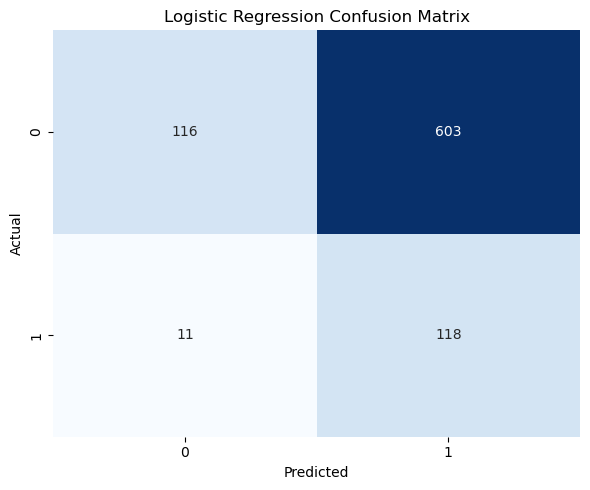

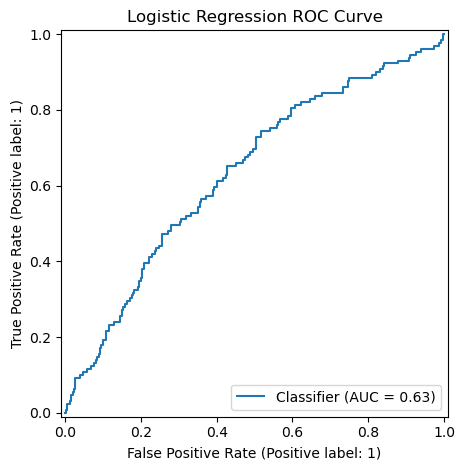


------------------------------------------------------------
Model: Random Forest
------------------------------------------------------------
Cross-validation ROC AUC: 0.6814 (+/- 0.0269)

Test Set Performance (Threshold=0.2):
  Accuracy:  0.4752
  Precision: 0.1890
  Recall:    0.7442
  F1-Score:  0.3014
  ROC AUC:   0.6150


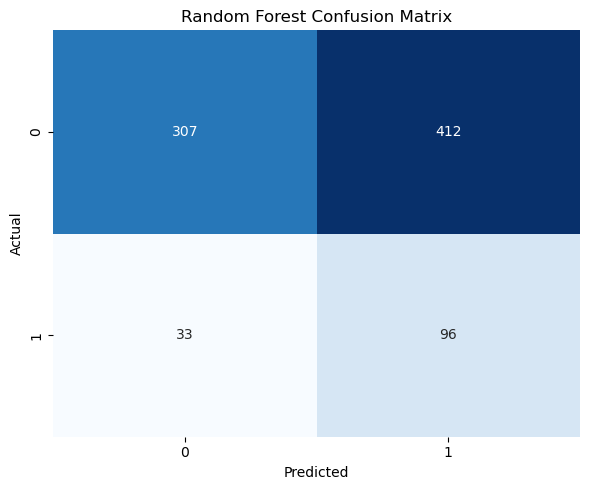

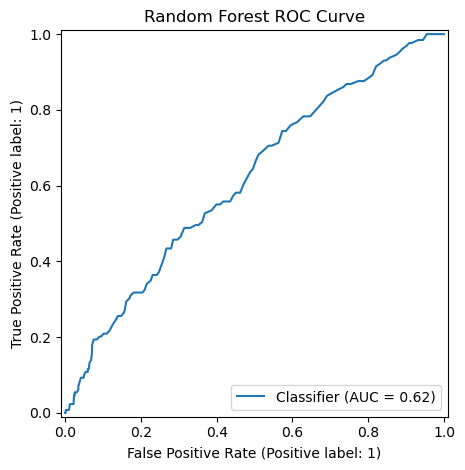

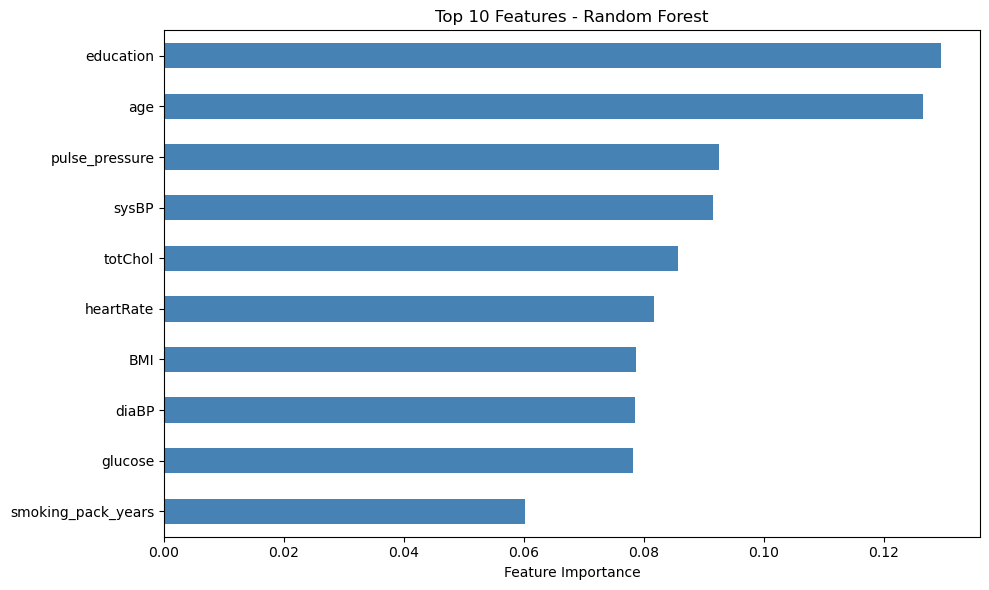


MODEL COMPARISON - Heart Disease
              Model  CV_ROC_AUC  Test_ROC_AUC  Accuracy  Precision   Recall       F1
Logistic Regression    0.686881      0.633050  0.275943   0.163662 0.914729 0.277647
      Random Forest    0.681389      0.615007  0.475236   0.188976 0.744186 0.301413
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Best CV ROC AUC: 0.6957

Test Set Performance (Tuned, Threshold=0.2):
  ROC AUC: 0.6613
  Accuracy: 0.2453
  Recall:   0.9767

Clustering on Heart Disease dataset


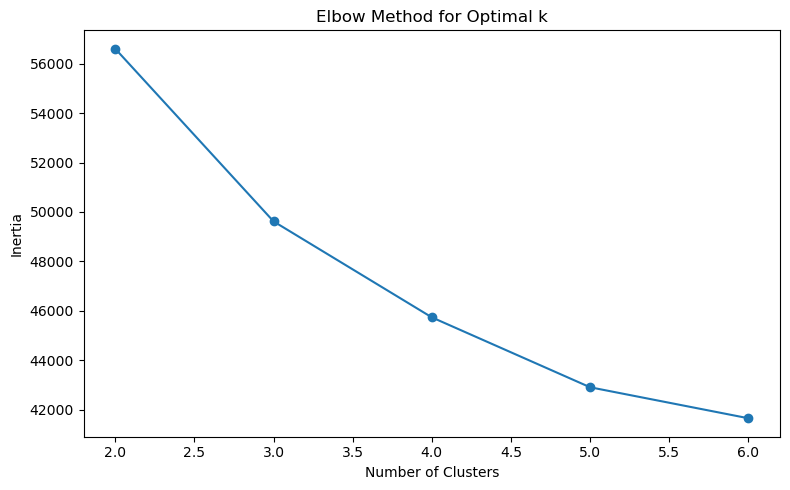

KMeans with 3 clusters: Silhouette Score = 0.1475


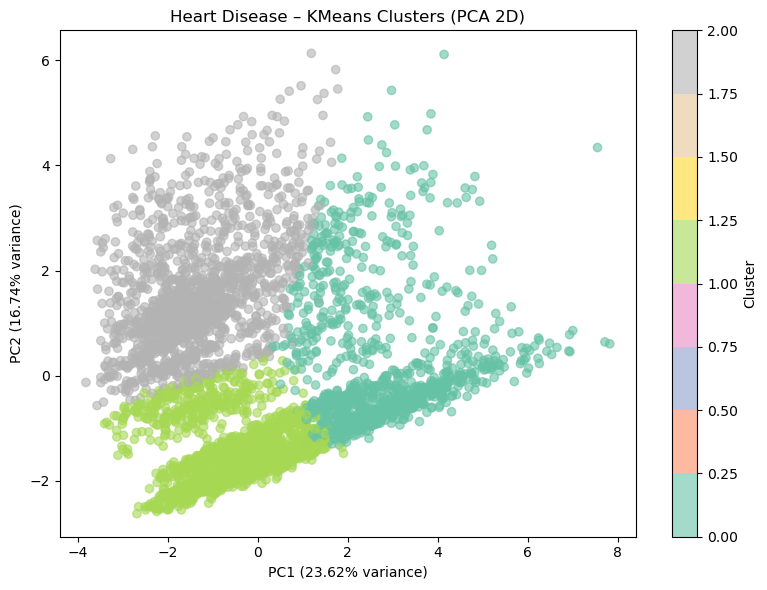


ALL ANALYSES COMPLETED!


In [1]:
# ==============================================
# 02_data_modelling_improved.py
# AI-Driven Predictive Analytics for Preventive Healthcare
# Sprint 3: Data Modelling (Improved)
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 

# ----------------------------------------------
# LOAD CLEANED DATA
# ----------------------------------------------
heart_path = "../data/processed/heart_disease_clean_v2.csv"
df_heart = pd.read_csv(heart_path)
print("Heart data shape:", df_heart.shape)

# ----------------------------------------------
# CLASSIFICATION
# ----------------------------------------------
def run_classification(df, target_col, dataset_name, risk_threshold=0.2, use_smote=True):
    print(f"\n{'='*60}")
    print(f"Classification on {dataset_name} dataset")
    print(f"{'='*60}")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define models with pipelines
    models = {
        "Logistic Regression": ImbPipeline([
            ("smote", SMOTE(random_state=42) if use_smote else "passthrough"),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
        ]),
        "Random Forest": ImbPipeline([
            ("smote", SMOTE(random_state=42) if use_smote else "passthrough"),
            ("clf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
        ])
    }

    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, pipeline in models.items():
        print(f"\n{'-'*60}")
        print(f"Model: {name}")
        print(f"{'-'*60}")
        
        # Cross-validation (on training only)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
        print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= risk_threshold).astype(int)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba)

        print(f"\nTest Set Performance (Threshold={risk_threshold}):")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  ROC AUC:   {roc:.4f}")

        results.append({
            "Model": name,
            "CV_ROC_AUC": cv_scores.mean(),
            "Test_ROC_AUC": roc,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        # ROC curve
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"{name} ROC Curve")
        plt.tight_layout()
        plt.show()

        # Feature importance for RF
        if name == "Random Forest":
            clf = pipeline.named_steps["clf"]
            importances = pd.Series(clf.feature_importances_, index=X.columns)
            top_features = importances.nlargest(10)
            plt.figure(figsize=(10,6))
            top_features.sort_values().plot(kind="barh", color="steelblue")
            plt.title(f"Top 10 Features - Random Forest")
            plt.xlabel("Feature Importance")
            plt.tight_layout()
            plt.show()

    results_df = pd.DataFrame(results)
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON - {dataset_name}")
    print(f"{'='*60}")
    print(results_df.to_string(index=False))

    return results_df


# ----------------------------------------------
# HYPERPARAMETER TUNING
# ----------------------------------------------
def tune_random_forest(df, target_col, dataset_name, risk_threshold=0.2):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
    ])

    param_grid = {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [5, 10, None],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2]
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best CV ROC AUC: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= risk_threshold).astype(int)

    print(f"\nTest Set Performance (Tuned, Threshold={risk_threshold}):")
    print(f"  ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  Recall:   {recall_score(y_test, y_pred):.4f}")

    return best_model


# ----------------------------------------------
# CLUSTERING
# ----------------------------------------------
def run_clustering(df, dataset_name, max_clusters=6, max_sample=1000):
    print(f"\n{'='*60}")
    print(f"Clustering on {dataset_name} dataset")
    print(f"{'='*60}")

    df_features = df.copy()
    if "TenYearCHD" in df_features.columns:
        df_features = df_features.drop(columns=["TenYearCHD"])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_features)

    # Elbow method
    inertias = []
    K = range(2, max_clusters+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8,5))
    plt.plot(K, inertias, marker="o")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal k")
    plt.tight_layout()
    plt.show()

    # Example clustering with chosen k
    kmeans = KMeans(n_clusters=3, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    if X_scaled.shape[0] > max_sample:
        X_samp, labels_samp = resample(X_scaled, cluster_labels, n_samples=max_sample, random_state=42)
    else:
        X_samp, labels_samp = X_scaled, cluster_labels

    score = silhouette_score(X_samp, labels_samp)
    print(f"KMeans with 3 clusters: Silhouette Score = {score:.4f}")

    # PCA plot
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap="Set2", alpha=0.6)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.title(f"{dataset_name} – KMeans Clusters (PCA 2D)")
    plt.colorbar(label="Cluster")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------
# RUN ANALYSES
# ----------------------------------------------
results_heart = run_classification(df_heart, target_col="TenYearCHD", dataset_name="Heart Disease")
best_rf_heart = tune_random_forest(df_heart, target_col="TenYearCHD", dataset_name="Heart Disease")
run_clustering(df_heart, dataset_name="Heart Disease", max_clusters=6)

print("\n" + "="*60)
print("ALL ANALYSES COMPLETED!")
print("="*60)
